In [289]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

##Data Preparation

In [290]:
train_data = pd.read_csv('zoo_animals_train.csv')
test_data  = pd.read_csv('zoo_animals_test.csv')

animal_names      = train_data['animal_name'].values
dropped_data      = pd.DataFrame({'animal_name': animal_names})
dropped_test_data = pd.DataFrame({'animal_name': test_data['animal_name'].values})
X_raw = train_data.drop(columns=['animal_name'])

# Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

# Normalization
normalized_data = pd.DataFrame(
    X_scaled,
    columns = X_raw.columns,
    index   = X_raw.index
)

# To check
train_data.info()
normalized_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   animal_name  98 non-null     object
 1   hair         98 non-null     int64 
 2   feathers     98 non-null     int64 
 3   eggs         98 non-null     int64 
 4   milk         98 non-null     int64 
 5   airborne     98 non-null     int64 
 6   aquatic      98 non-null     int64 
 7   predator     98 non-null     int64 
 8   toothed      98 non-null     int64 
 9   backbone     98 non-null     int64 
 10  breathes     98 non-null     int64 
 11  venomous     98 non-null     int64 
 12  fins         98 non-null     int64 
 13  legs         98 non-null     int64 
 14  tail         98 non-null     int64 
 15  domestic     98 non-null     int64 
 16  catsize      98 non-null     int64 
dtypes: int64(16), object(1)
memory usage: 13.1+ KB


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0


Descriptive statistics for binary features:

            hair   feathers       eggs       milk   airborne    aquatic  \
count  98.000000  98.000000  98.000000  98.000000  98.000000  98.000000   
mean    0.418367   0.193878   0.591837   0.397959   0.234694   0.367347   
std     0.495827   0.397367   0.494021   0.491994   0.425986   0.484561   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   1.000000   0.000000   0.000000   0.000000   
75%     1.000000   0.000000   1.000000   1.000000   0.000000   1.000000   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

        predator    toothed   backbone   breathes   venomous       fins  \
count  98.000000  98.000000  98.000000  98.000000  98.000000  98.000000   
mean    0.561224   0.602041   0.816327   0.785714   0.081633   0.173469   
std     0.498789   0.491994   0.389209   0.412436   0.

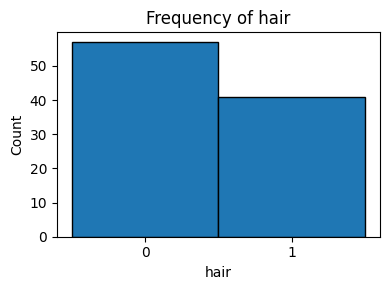

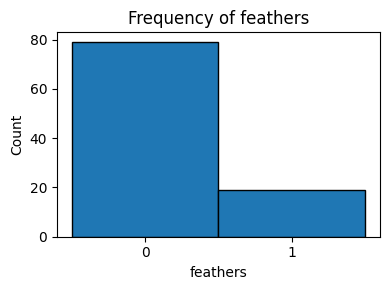

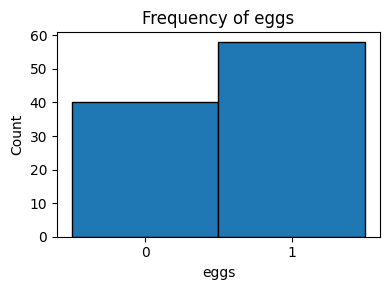

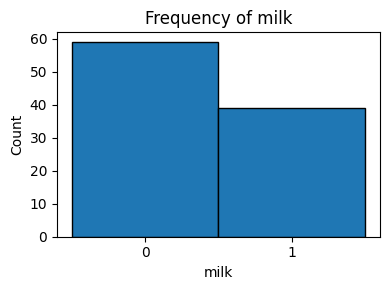

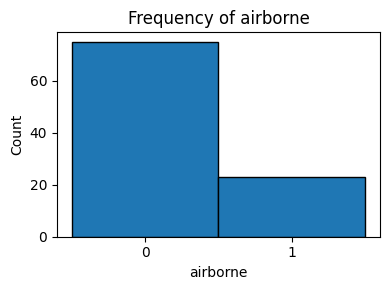

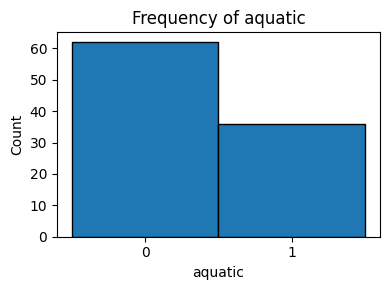

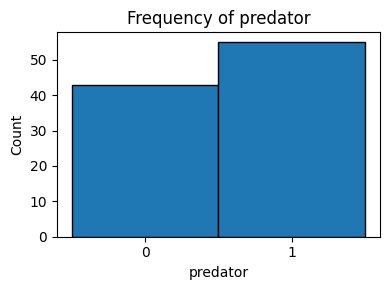

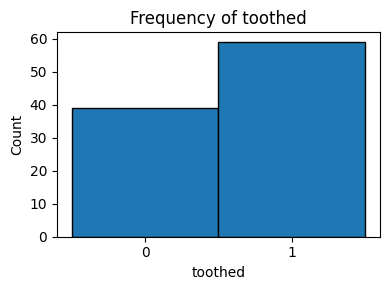

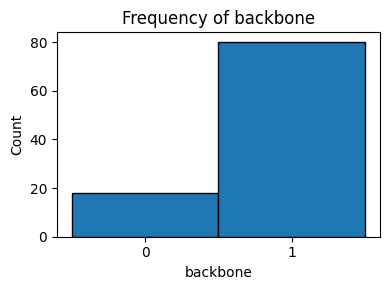

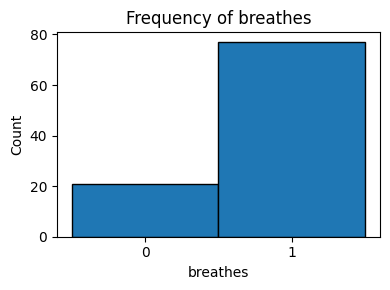

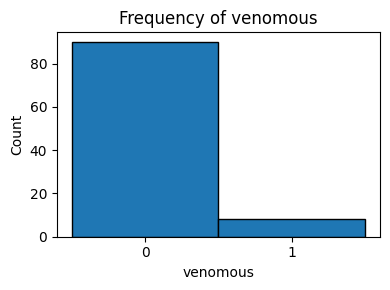

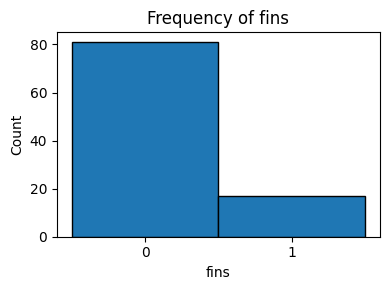

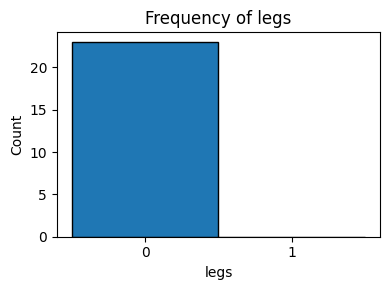

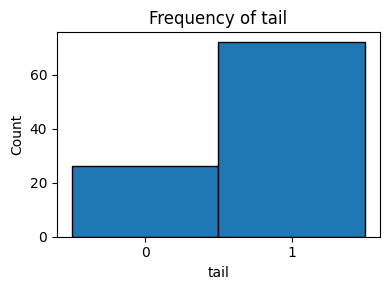

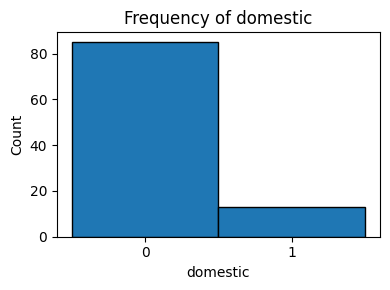

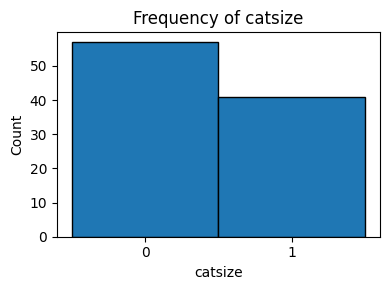

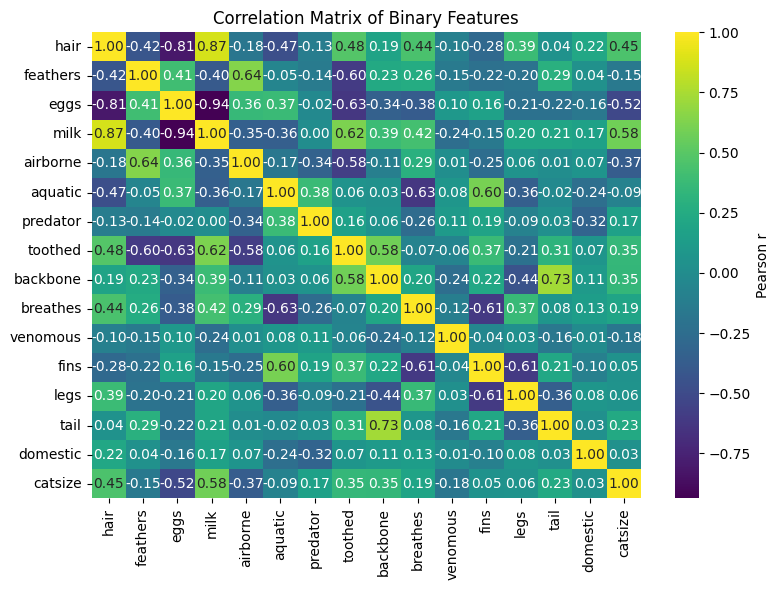

In [291]:
# Select only the binary feature columns
binary_features = ['hair', 'feathers', 'eggs', 'milk', 'airborne',
                   'aquatic', 'predator', 'toothed', 'backbone',
                   'breathes', 'venomous', 'fins', 'legs', 'tail',
                   'domestic', 'catsize']

df_binary = train_data[binary_features]

# Descriptive statistics
print("Descriptive statistics for binary features:\n")
print(df_binary.describe())

# Frequency histograms for each feature
for feature in binary_features:
    plt.figure(figsize=(4,3))
    plt.hist(df_binary[feature], bins=[-0.5, 0.5, 1.5], edgecolor='black')
    plt.xticks([0, 1])
    plt.title(f"Frequency of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Correlation matrix and heatmap
corr_matrix = df_binary.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis",
            cbar_kws={'label': 'Pearson r'})
plt.title("Correlation Matrix of Binary Features")
plt.tight_layout()
plt.show()

##Define SOM class

In [292]:
map_side = 15
num_features = normalized_data.shape[1]
initial_weight_matrix = np.random.rand(map_side, map_side, num_features)
initial_lr = 0.2
epochs = 300000
initial_sigma = 12
output_index = np.indices((map_side, map_side))

In [293]:
# BMU calculation
def calculate_bmu(input_pattern, weight_matrix):
    distances = np.linalg.norm(weight_matrix - input_pattern, axis=2)
    flat_idx = np.argmin(distances)
    bmu_idx = np.unravel_index(flat_idx, distances.shape)
    return weight_matrix[bmu_idx], bmu_idx

In [294]:
# Learning rate decay
def learning_rate_variation(lr0, t, epochs):
    return lr0 * np.exp(-t / (0.9 * epochs))

In [295]:
# Neighborhood calculation
def neighborhood_variation(sigma0, t, epochs):
    sigma_t = sigma0 * np.exp(-t / epochs)
    return max(sigma_t, 2.0)

In [296]:
# BMU influence based on the neighborhood
def calculate_bmu_influence(
    distance_to_bmu,
    current_neighborhood):

    return np.exp(-distance_to_bmu**2/(2*(current_neighborhood**2)))

In [297]:
def quantization_error(
    model,
    input_data):
    """
    Calculate the quantization error for a given model and dataset.

    Parameters:
    - model: The model used for Best Matching Unit (BMU) calculation.
    - input_data: Iterable dataset (e.g., list, numpy array) where each item represents a data point.

    Returns:
    - Mean quantization error across the input data.
    """

    distances = [calculate_bmu(data_point, model)[0] for data_point in input_data]

    return np.mean(distances)

In [298]:
def calculate_first_second_bmu(
    model,
    input_vector):

    distances = np.linalg.norm(model - input_vector, axis=1)

    first_bmu_index = np.argmin(distances)
    bmu_idx = np.unravel_index(first_bmu_index, distances.shape)
    first_bmu_distance = distances[bmu_idx]
    first_bmu_weights = model[bmu_idx]

    distances[bmu_idx] = np.inf

    second_bmu_index = np.argmin(distances)
    bmu_idx2 = np.unravel_index(second_bmu_index, distances.shape)
    second_bmu_distance = distances[bmu_idx2]
    second_bmu_weights = model[bmu_idx2]

    return first_bmu_index, first_bmu_distance, first_bmu_weights, second_bmu_index, second_bmu_distance, second_bmu_weights


def topographic_error(
    model,
    input_data,
    threshold = 0.2):

    """
    Compute the topographic error for a given input and weight matrix.

    Parameters:
    - input_matrix (numpy.ndarray): The dataset where each row is an input vector.
    - weight_matrix (numpy.ndarray): The weight matrix representing the model.
    - threshold (float): Distance threshold to determine topographic error (default: 0.2).

    Returns:
    - float: The topographic error, i.e., the fraction of input vectors for which
      the first and second best-matching units (BMUs) are not adjacent.
    """

    count = sum(
        np.linalg.norm(np.array(coord1) - np.array(coord2)) > threshold
        for input_vector in input_data
        for _, _, coord1, _, _, coord2 in [calculate_first_second_bmu(model, input_vector)]
    )

    return count / len(input_data)

In [299]:
# Print map
def paint_map(
    value_matrix,
    epochs,
    quantization_error,
    topographic_error,
    i):
    fig = plt.figure()

    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, value_matrix.shape[0]+1))
    ax.set_ylim((0, value_matrix.shape[1]+1))
    ax.set_title('Self-Organizing Map after %d iterations. QE: %f TE: %f' % (epochs, quantization_error, topographic_error))

    for x in range(1, map_side +1):
      for y in range(1, map_side + 1):
        ax.add_patch(
            patches.Rectangle((x-0.5, y-0.5), 1, 1,
            facecolor = value_matrix[x-1, y-1, :3],
            edgecolor = 'none'))
    plt.show()

##Train SOM

In [300]:
# Training algorithm
def train(
    training_data,
    weight_matrix,
    lr,
    neighborhood,
    i):

  paint_map(weight_matrix, 1, 0, 0, i)

  for epoch in range(1, epochs + 1):

    input_sample = training_data[np.random.randint(0, len(training_data) - 1)]
    learning_rate = learning_rate_variation(lr, epoch, epochs)
    neighborhood = neighborhood_variation(neighborhood, epoch, epochs)

    bmu, bmu_idx = calculate_bmu(
        input_sample,
        weight_matrix)

    x, y = output_index

    distance_to_bmu = np.sqrt((x - bmu_idx[0])**2 + (y - bmu_idx[1])**2)

    bmu_influence = calculate_bmu_influence(distance_to_bmu, neighborhood)

    weight_matrix += lr * bmu_influence[..., np.newaxis] * (input_sample - weight_matrix)

    if epoch%5000 == 0:
      qe = quantization_error(weight_matrix, training_data)
      te = topographic_error(weight_matrix, training_data)
      paint_map(weight_matrix, epoch, qe, te, i)

  return weight_matrix

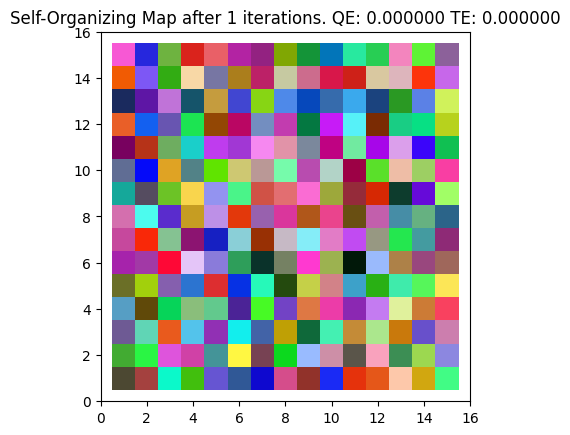

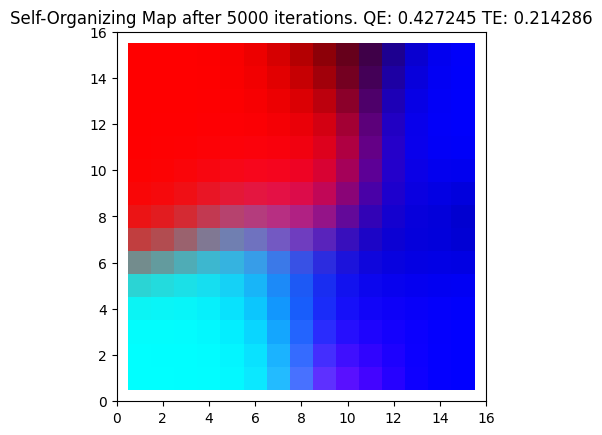

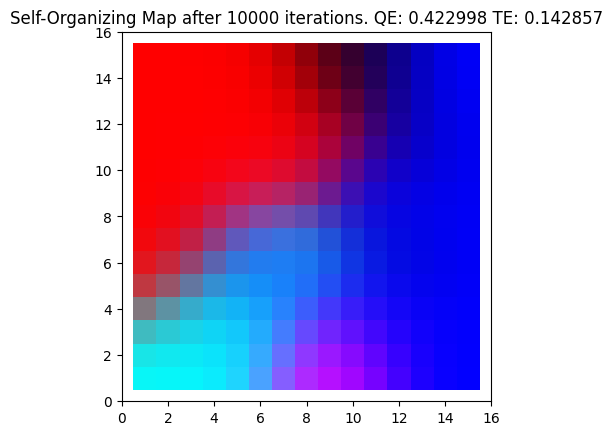

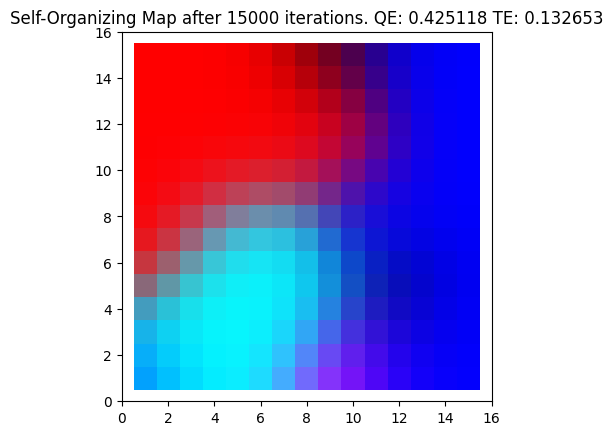

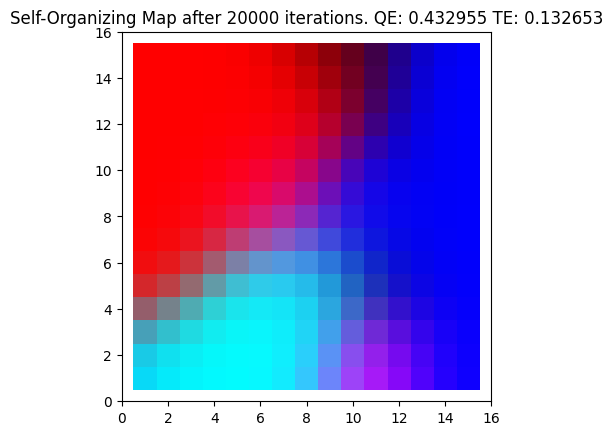

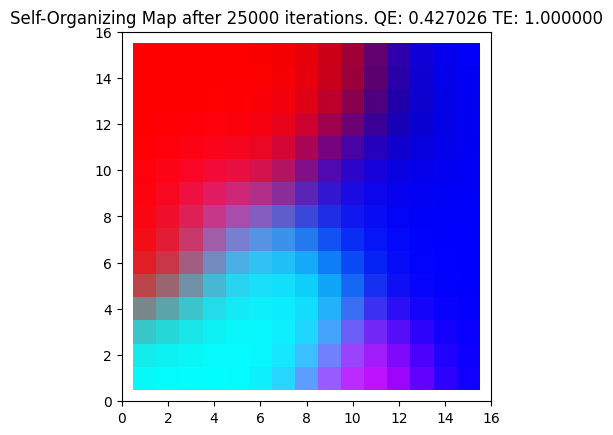

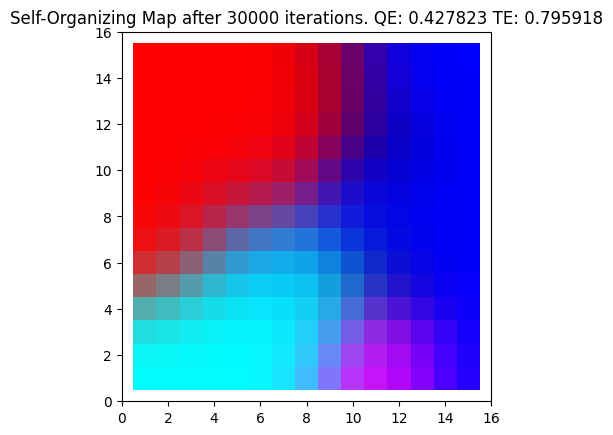

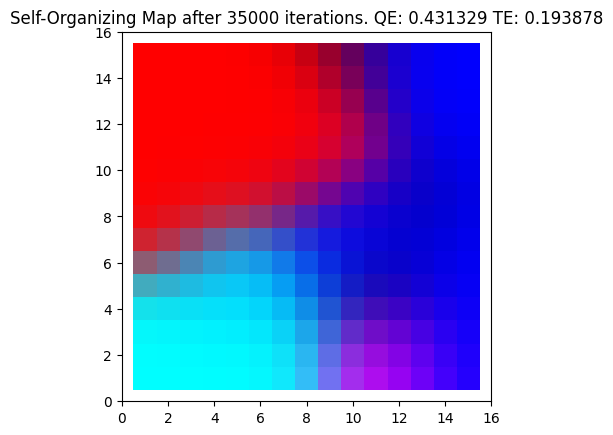

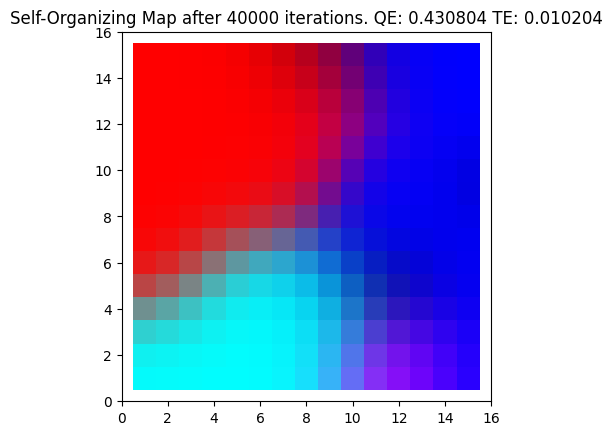

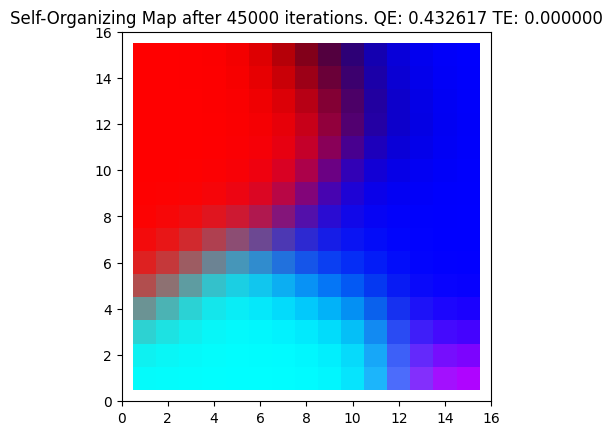

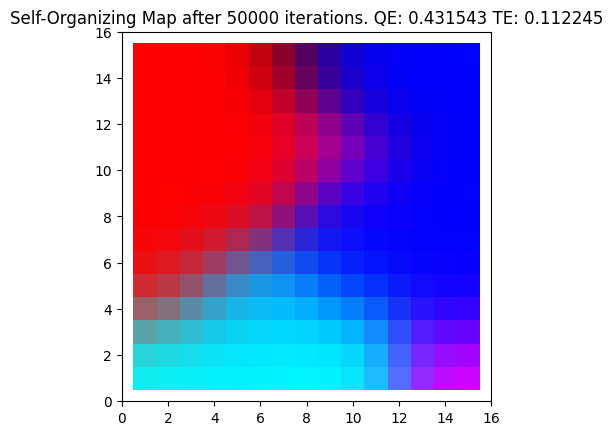

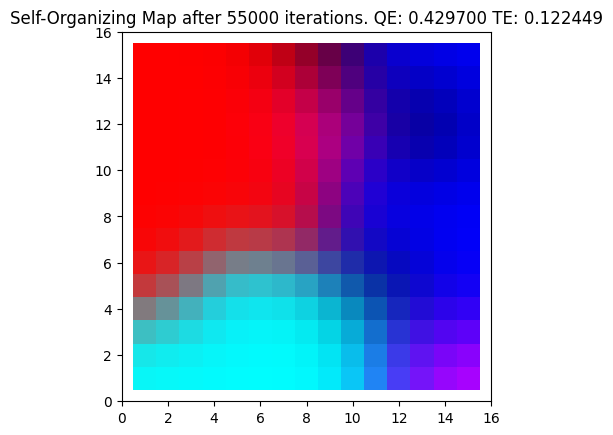

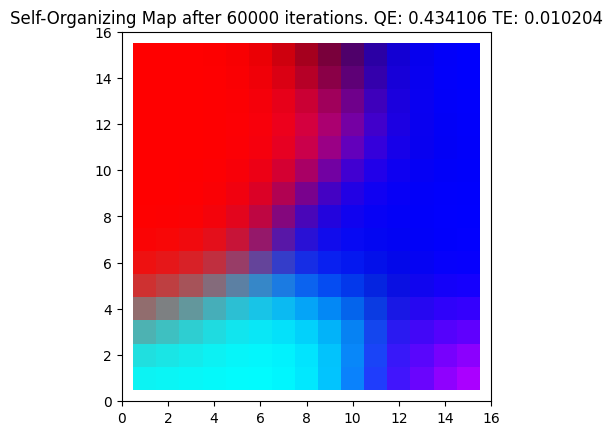

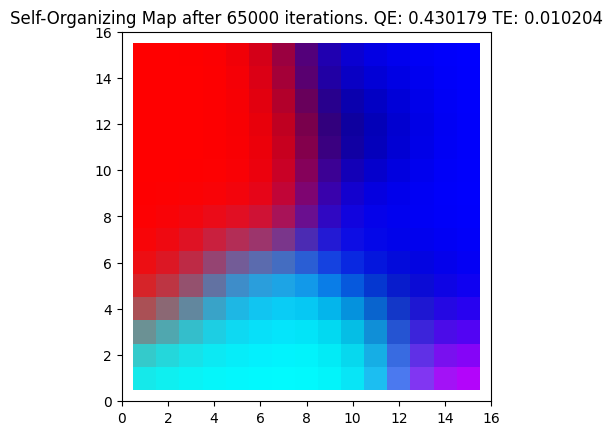

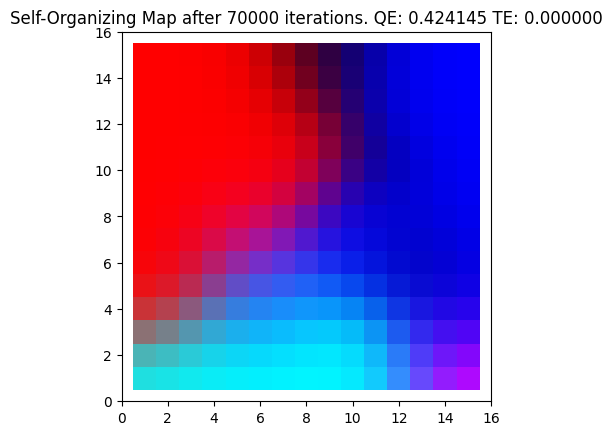

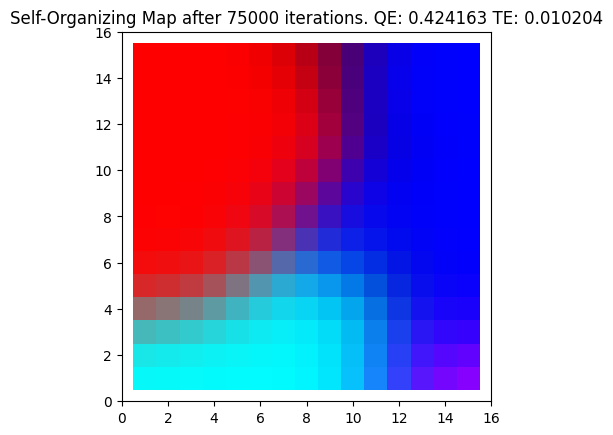

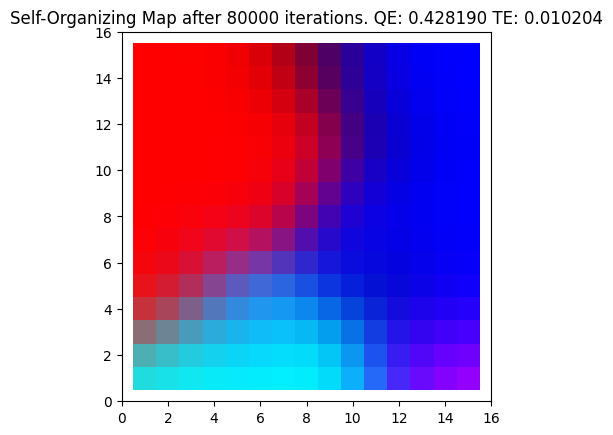

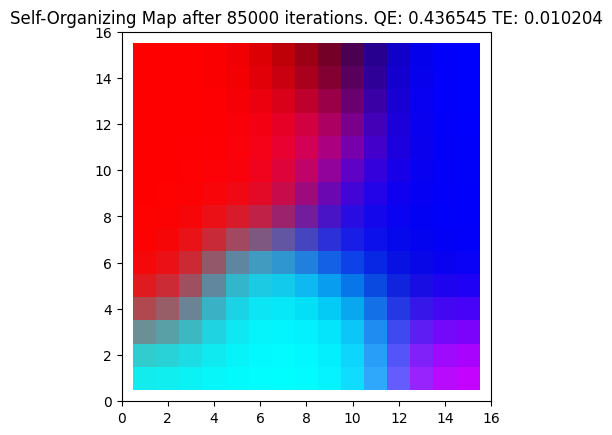

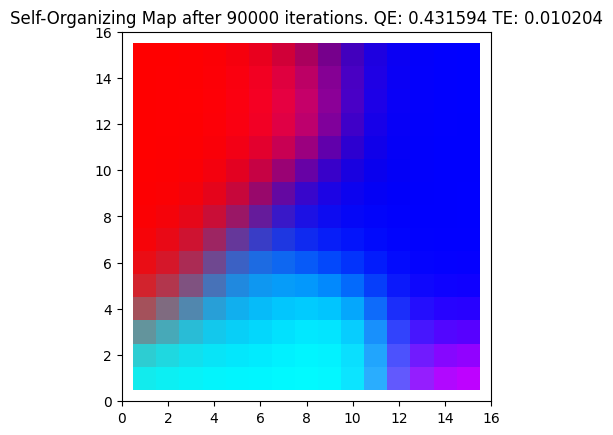

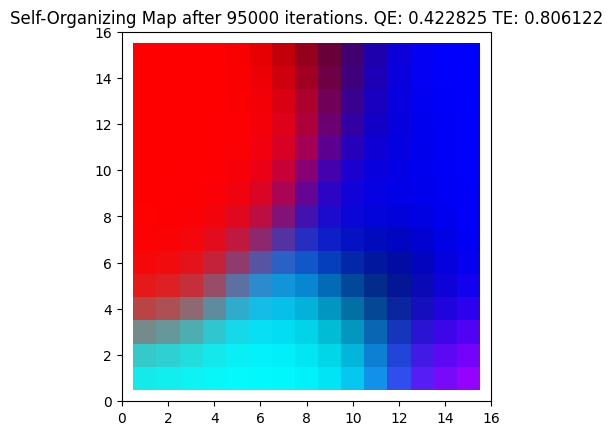

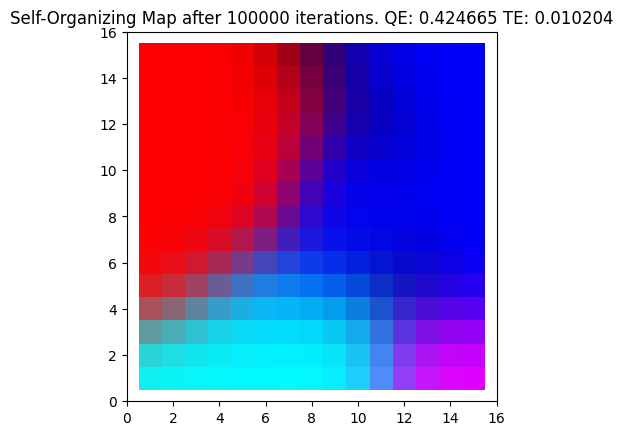

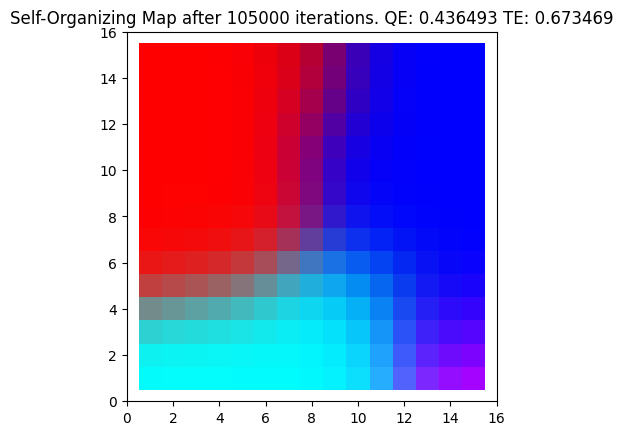

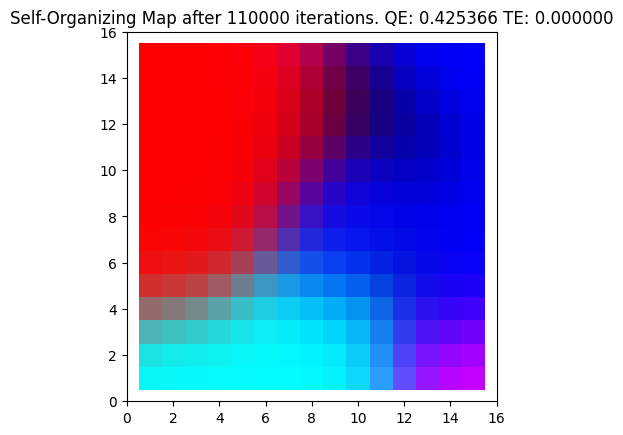

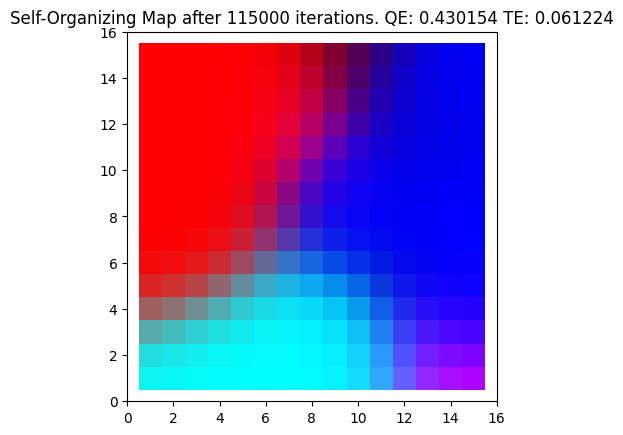

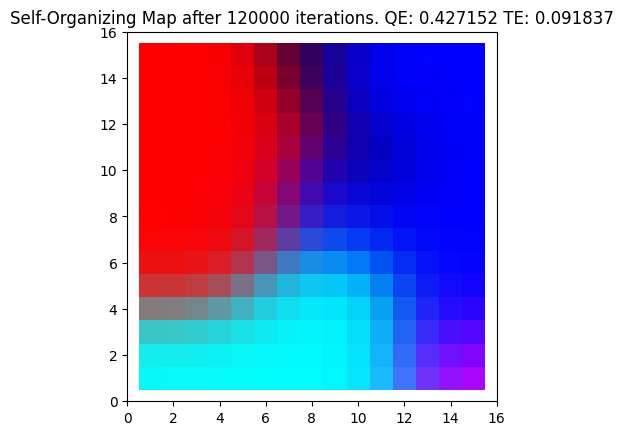

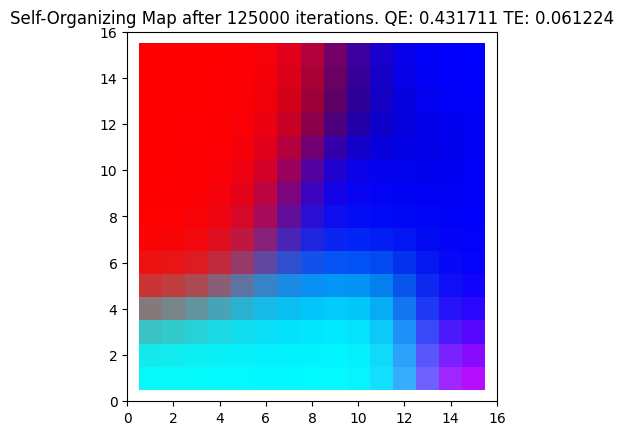

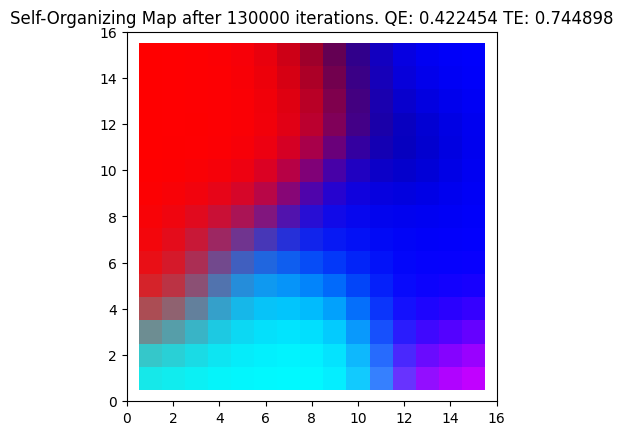

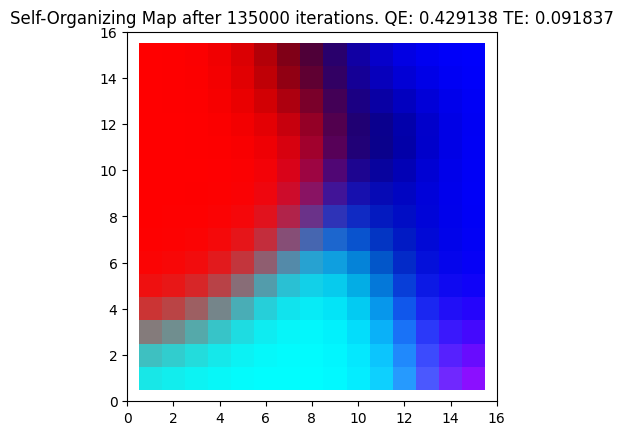

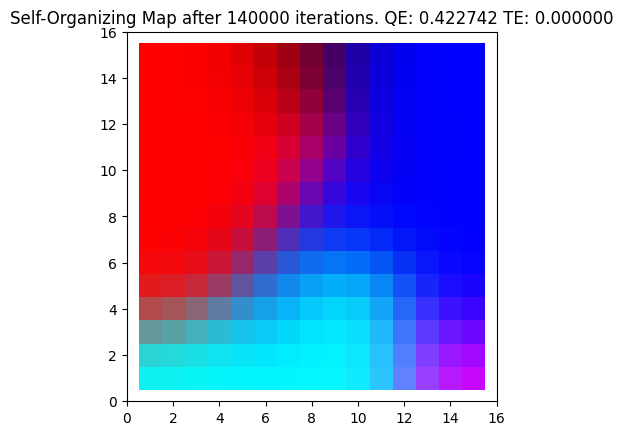

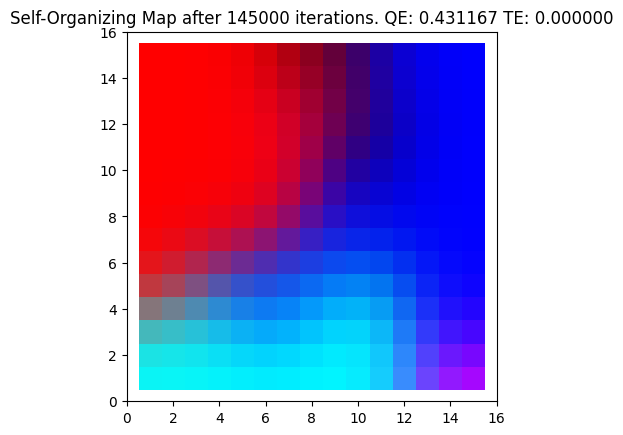

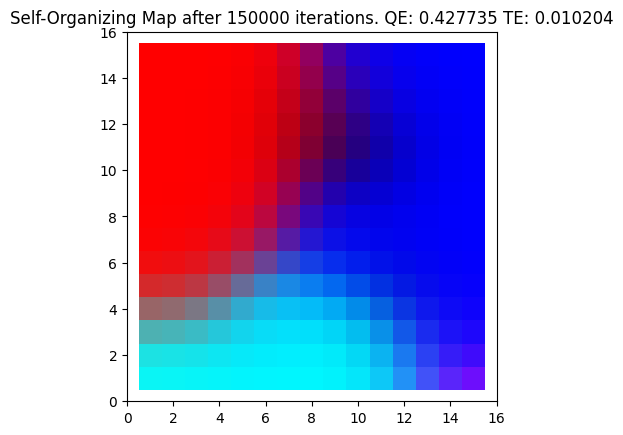

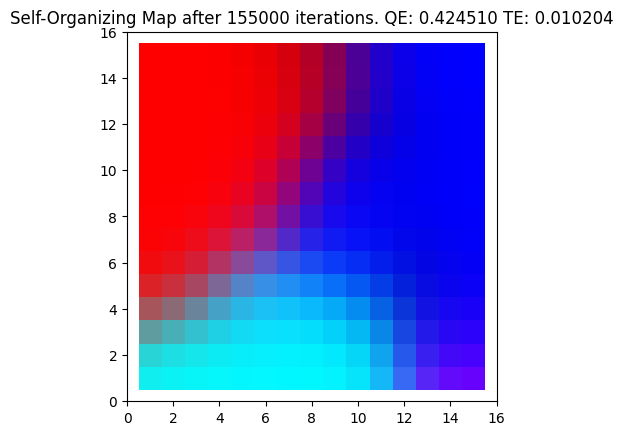

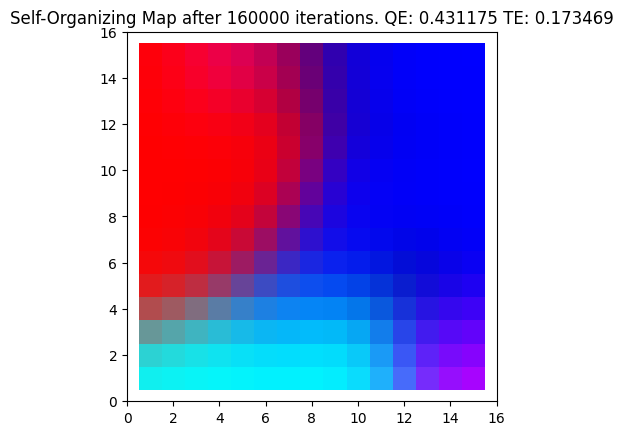

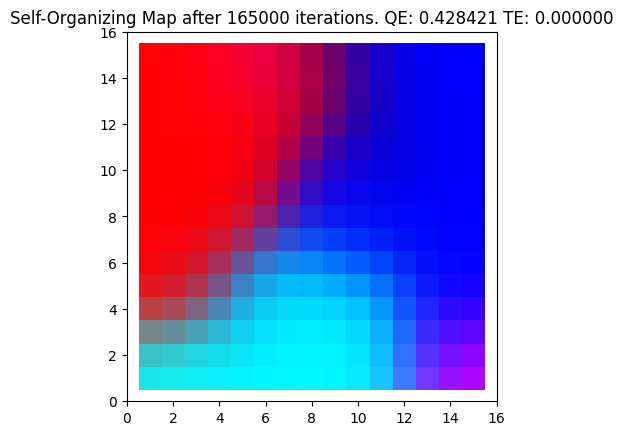

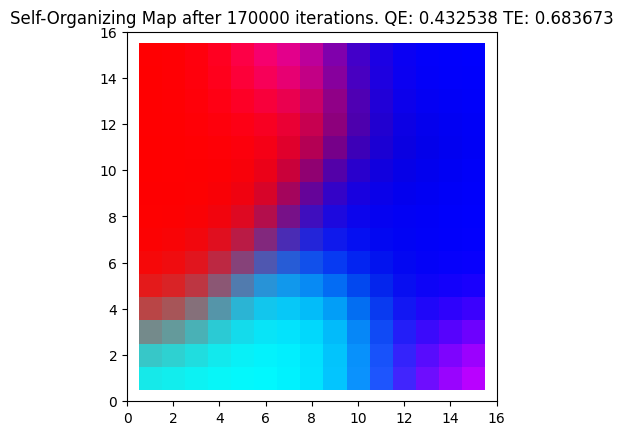

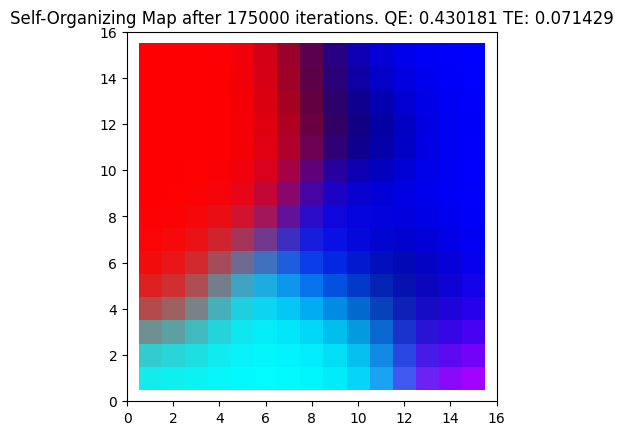

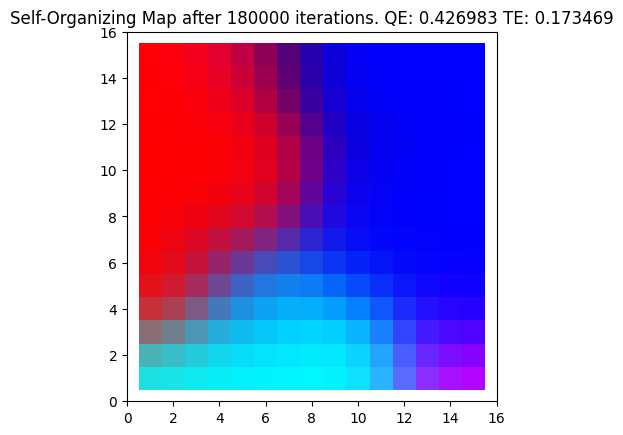

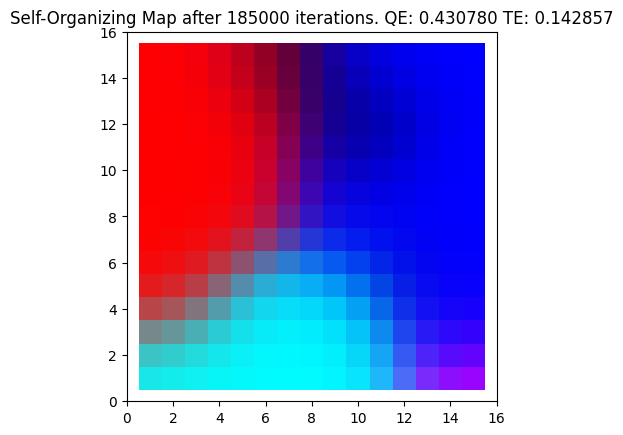

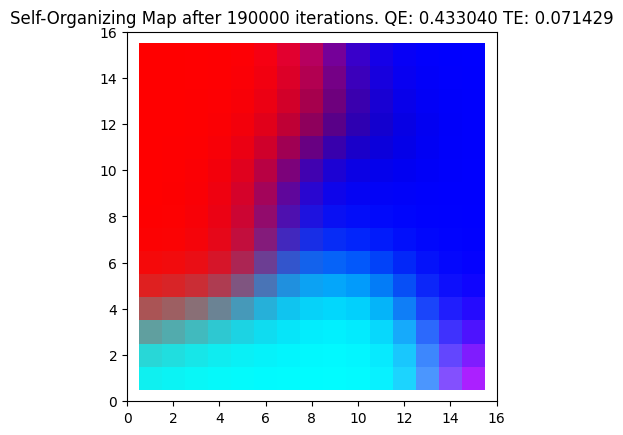

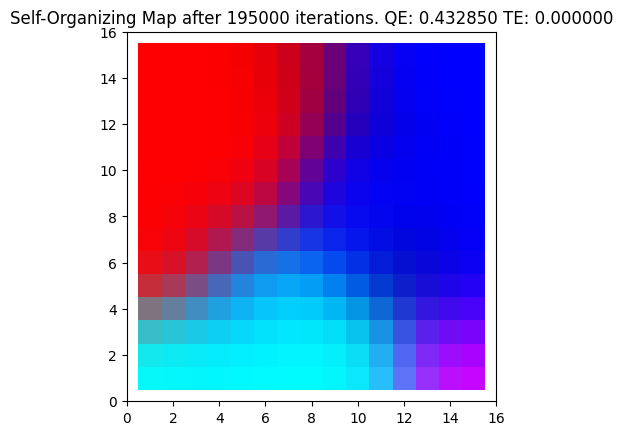

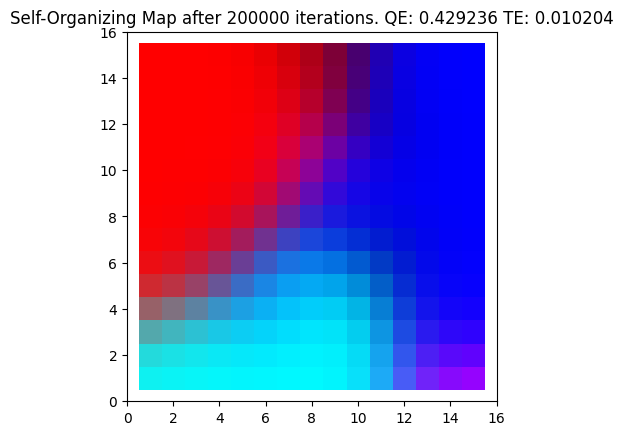

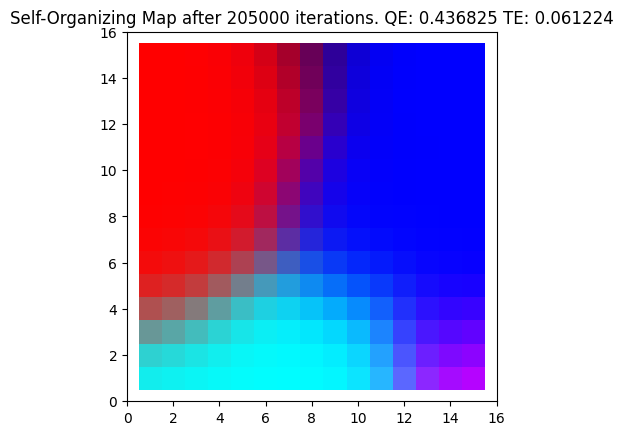

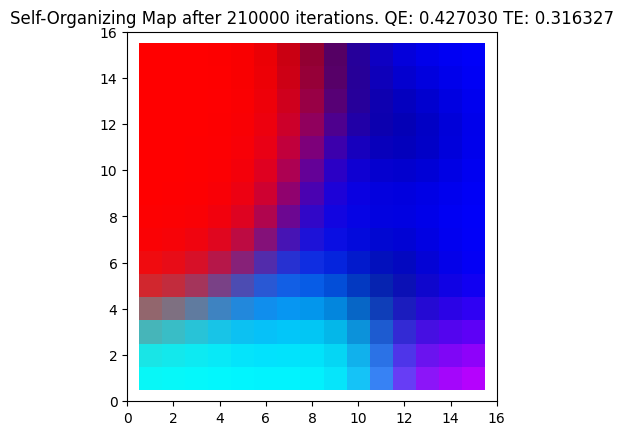

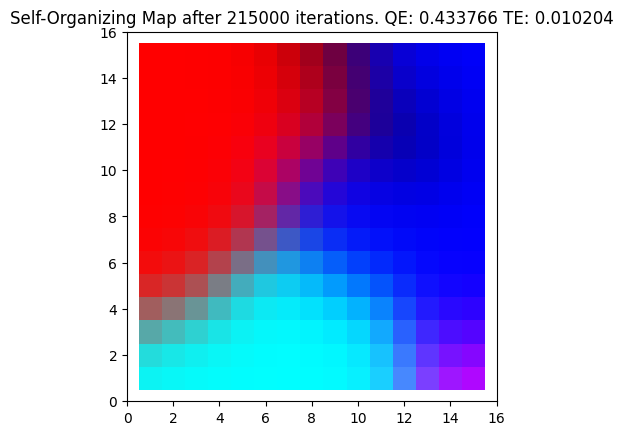

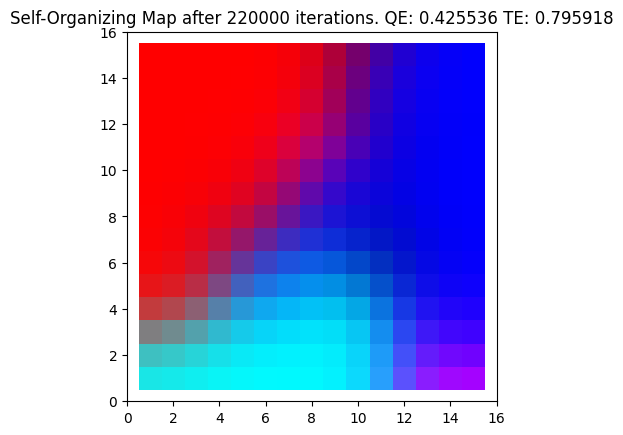

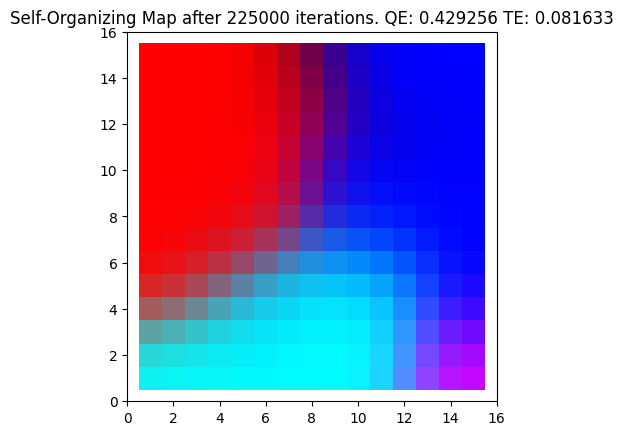

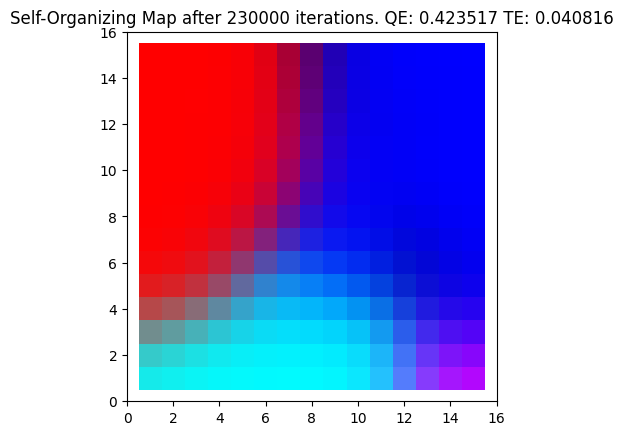

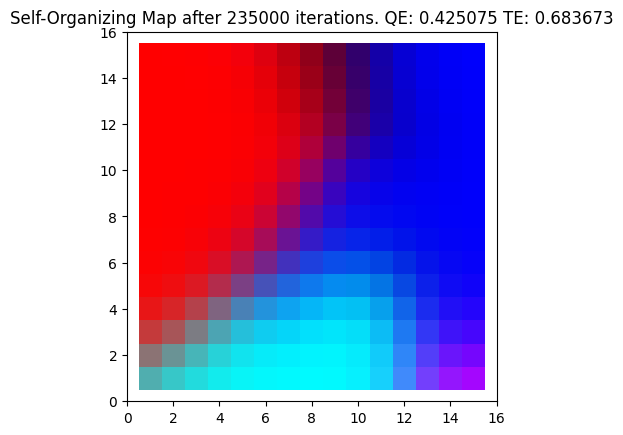

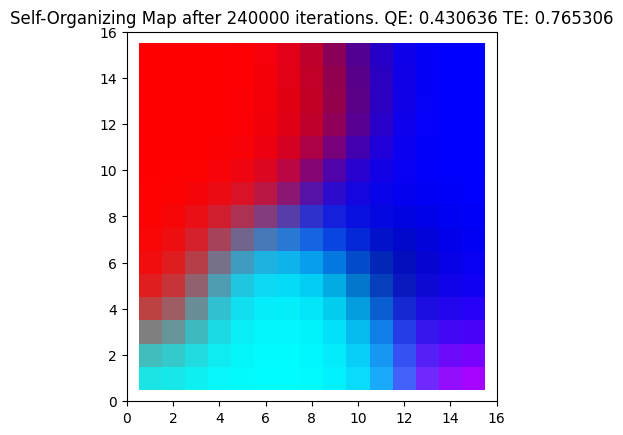

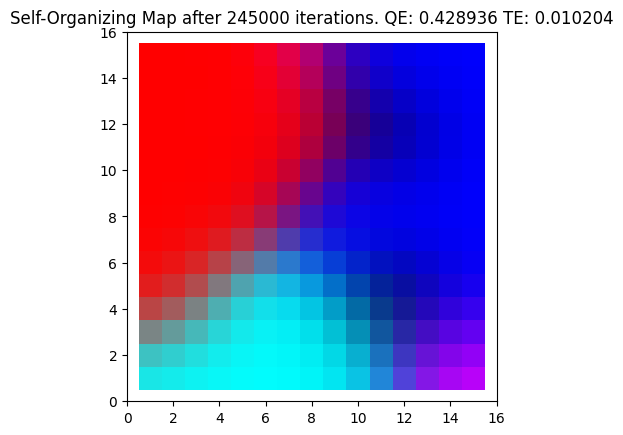

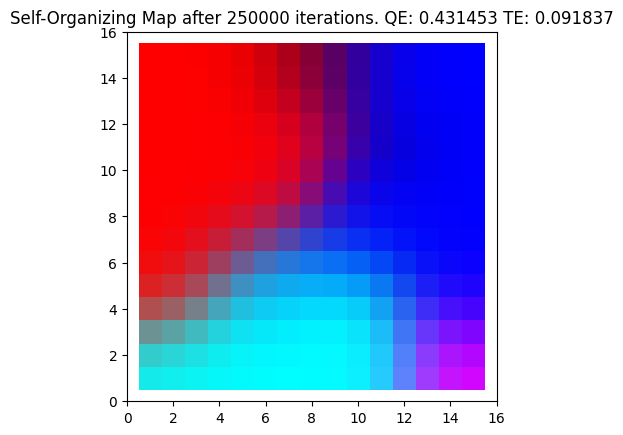

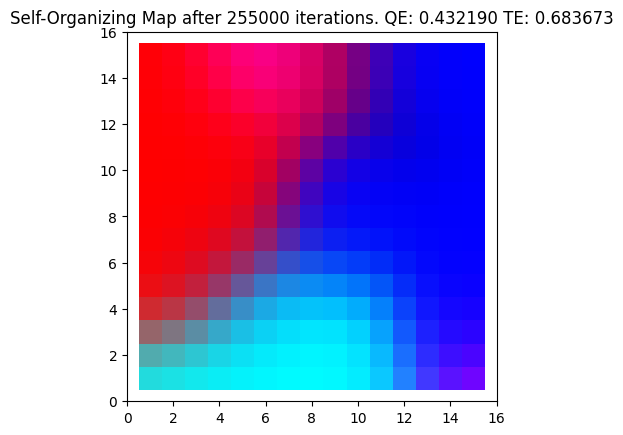

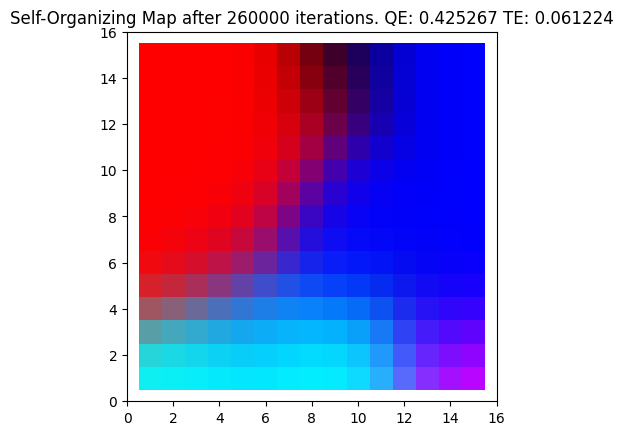

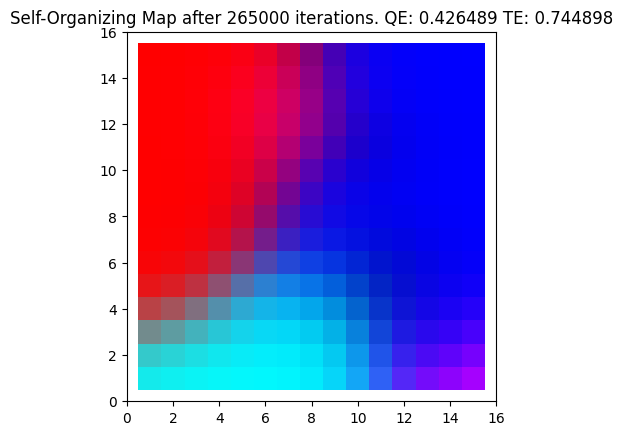

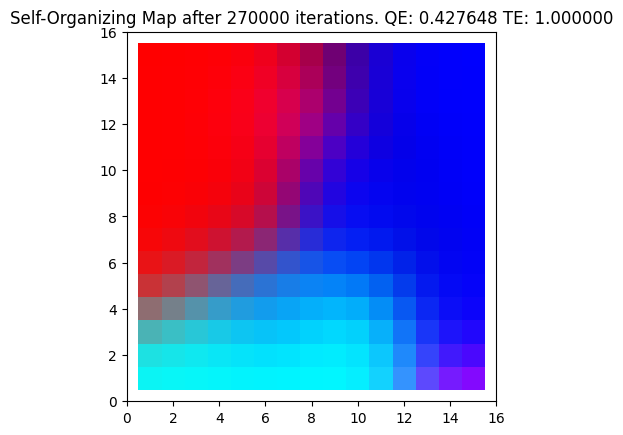

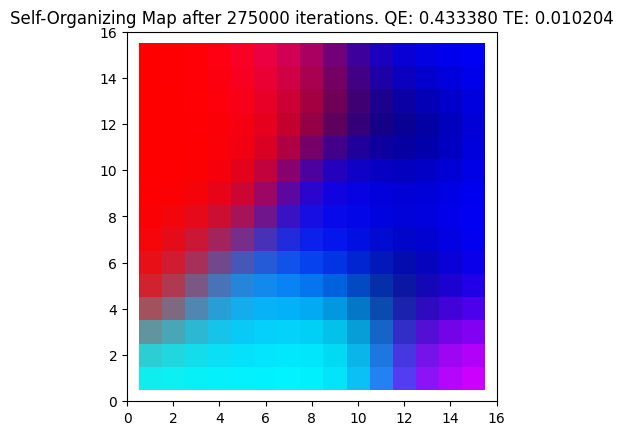

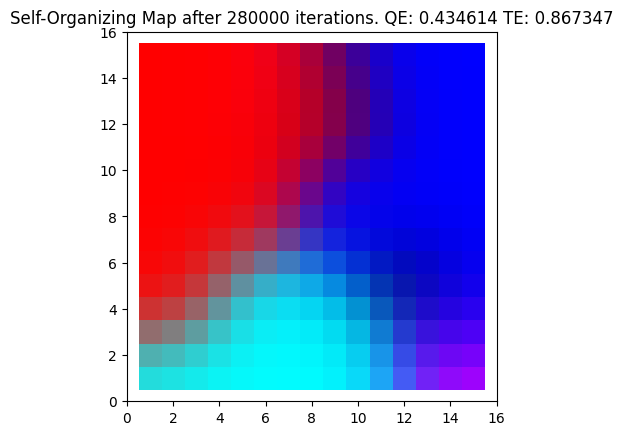

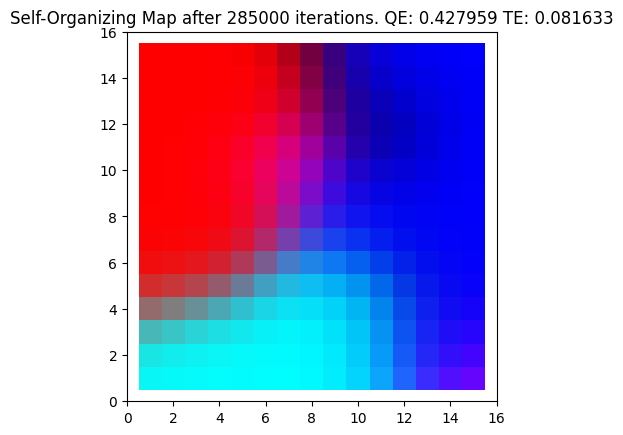

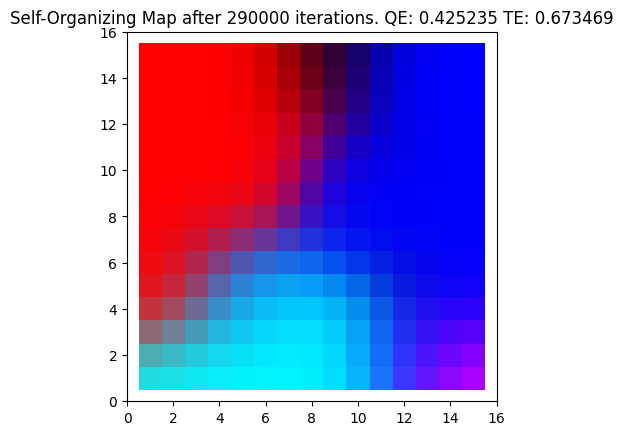

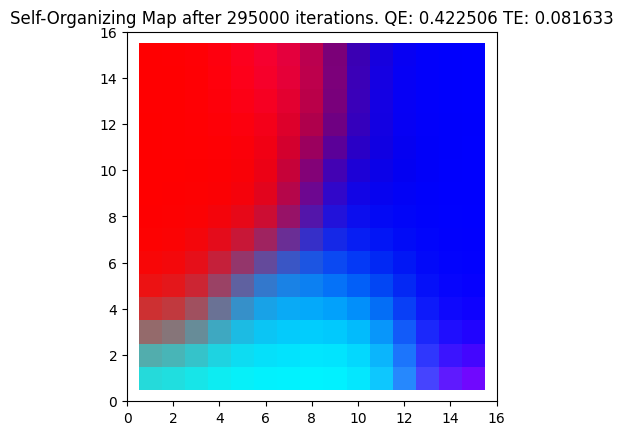

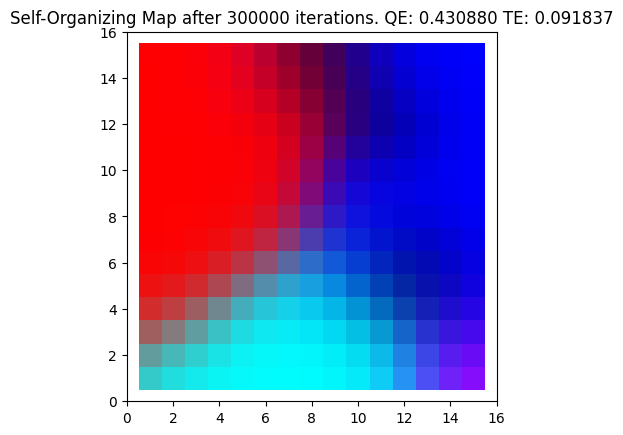

Quantization Error: 0.4309
Topographic Error:  0.0918


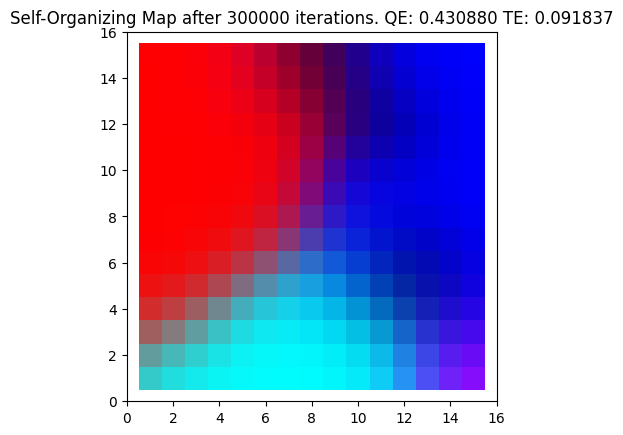

In [301]:
# Training array from the DataFrame
train_array = normalized_data.values

# Training
model = train(
    train_array,
    initial_weight_matrix,
    initial_lr,
    initial_sigma,
    i=0
)

# Errors calculations
qe = quantization_error(model, train_array)
te = topographic_error(model, train_array)

print(f"Quantization Error: {qe:.4f}")
print(f"Topographic Error:  {te:.4f}")

# Print final map
paint_map(model, epochs, qe, te, i=0)

##Evaluation

In [302]:
qe = quantization_error(model, train_array)
te = topographic_error(model, train_array)
print(qe)
print(te)

0.43087973534295776
0.09183673469387756


In [303]:
k_values = range(2, 35)

models = []
WCSS = []
silhouette_scores = []

for k in k_values:

    model_cluster = KMeans(
        n_clusters = k,
        random_state = 12345678,
        max_iter = 30,
        n_init = 'auto')

    models.append(model)

    y_pred = model_cluster.fit_predict(train_array)

    WCSS.append(model_cluster.inertia_)

    silhouette_scores.append(
        silhouette_score(
            train_array,
            model_cluster.labels_,
            metric = 'euclidean'))

##Elbow Method

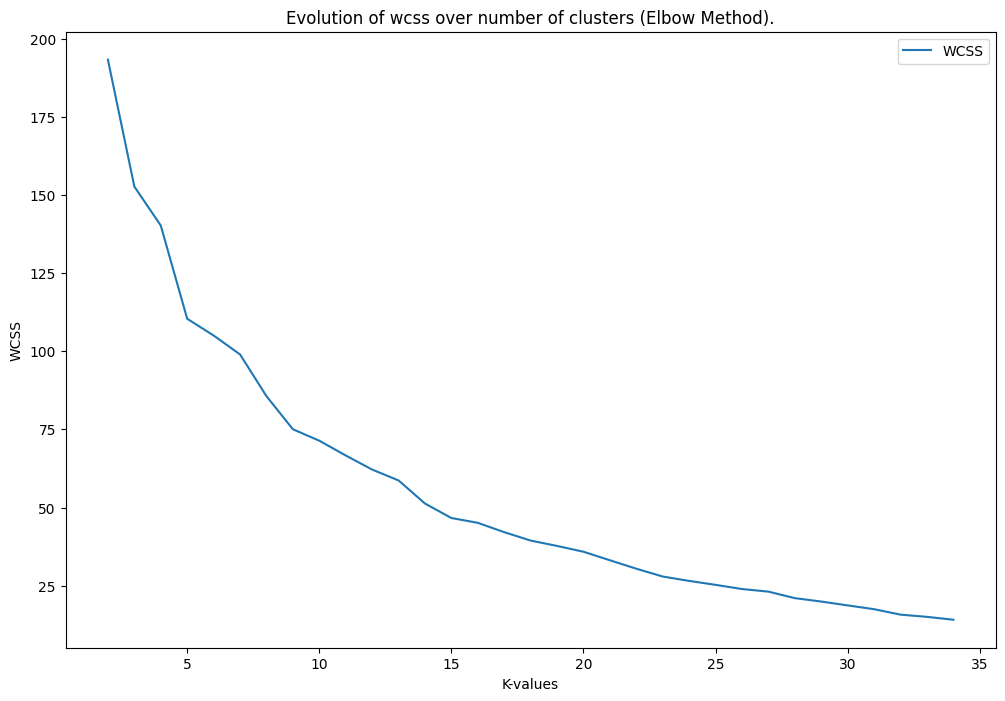

In [304]:
plt.figure(figsize=(12, 8))

sns.lineplot(
    x = k_values,
    y = WCSS,
    label='WCSS')

plt.legend()

plt.title('Evolution of wcss over number of clusters (Elbow Method).')
plt.xlabel('K-values')
plt.ylabel('WCSS')

plt.show()

##Silhoutte Score

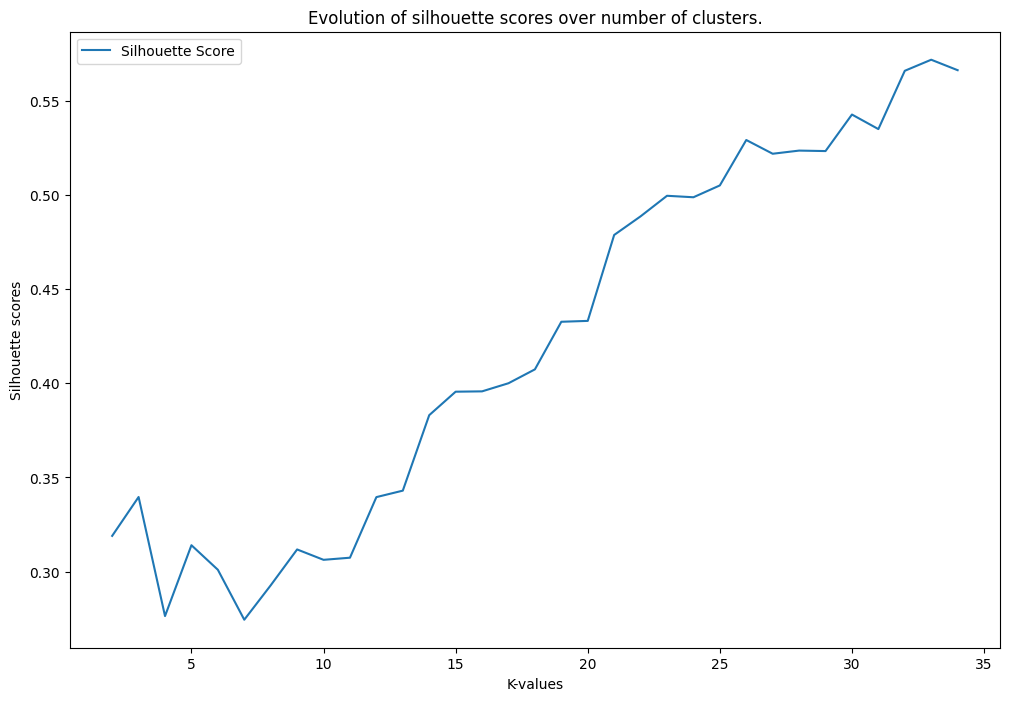

In [305]:
plt.figure(figsize=(12, 8))

sns.lineplot(
    x = k_values,
    y = silhouette_scores,
    label='Silhouette Score')

plt.legend()

plt.title('Evolution of silhouette scores over number of clusters.')
plt.xlabel('K-values')
plt.ylabel('Silhouette scores')

plt.show()

##Clusters map

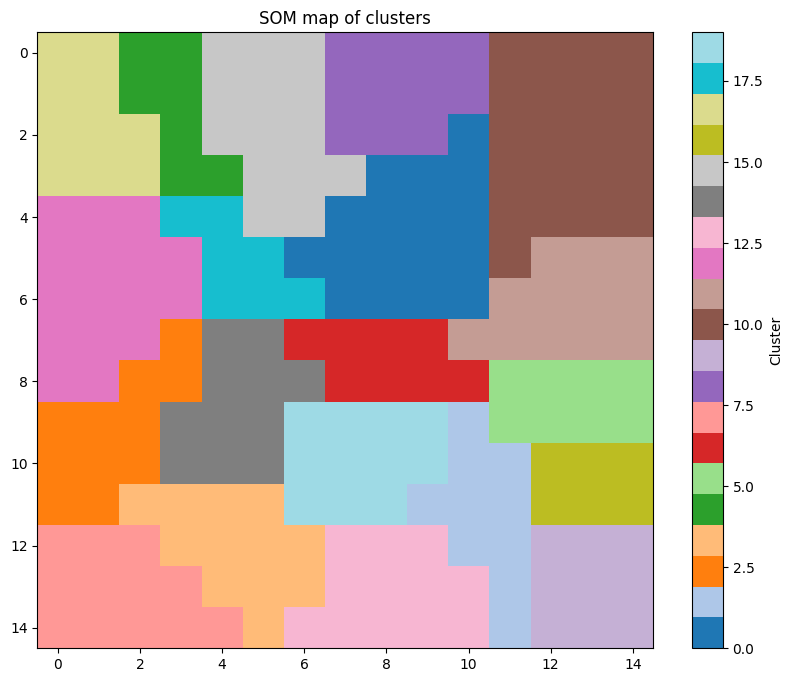

In [306]:
kmeans = KMeans(n_clusters=20, random_state=42)
cluster_labels = kmeans.fit_predict(model.reshape(-1, model.shape[-1]))

cluster_map = cluster_labels.reshape(map_side, map_side)

plt.figure(figsize=(10, 8))
plt.imshow(cluster_map, cmap='tab20', interpolation='nearest')
plt.colorbar(label='Cluster')
plt.title('SOM map of clusters')
plt.show()

##Classification Map

/tmp/ipython-input-307-28274182.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap   = plt.cm.get_cmap("tab10", num_clusters)


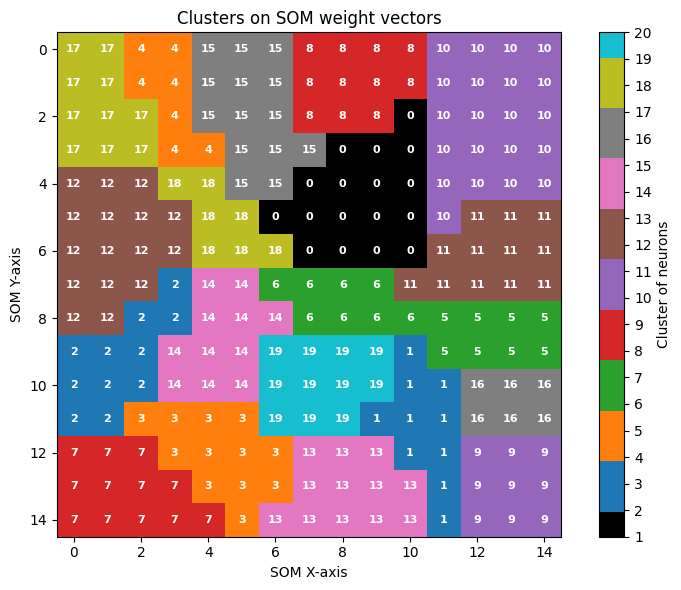

----- Animals per neuron (BMU) -----
Neuron (np.int64(0), np.int64(3)) (Cluster 4): ['fruitbat', 'vampire']
Neuron (np.int64(0), np.int64(4)) (Cluster 15): ['hare', 'squirrel', 'vole']
Neuron (np.int64(0), np.int64(6)) (Cluster 15): ['cavy', 'hamster']
Neuron (np.int64(0), np.int64(8)) (Cluster 8): ['calf', 'goat', 'pony', 'reindeer']
Neuron (np.int64(0), np.int64(10)) (Cluster 8): ['girl', 'pussycat']
Neuron (np.int64(0), np.int64(14)) (Cluster 10): ['mole', 'opossum']
Neuron (np.int64(1), np.int64(0)) (Cluster 17): ['chicken', 'dove', 'parakeet']
Neuron (np.int64(1), np.int64(14)) (Cluster 10): ['boar', 'cheetah', 'leopard', 'lion', 'lynx', 'mongoose', 'polecat', 'puma', 'raccoon', 'wolf']
Neuron (np.int64(3), np.int64(0)) (Cluster 17): ['lark', 'pheasant', 'sparrow', 'wren']
Neuron (np.int64(4), np.int64(7)) (Cluster 0): ['antelope', 'buffalo', 'deer', 'elephant', 'wallaby']
Neuron (np.int64(4), np.int64(14)) (Cluster 10): ['mink']
Neuron (np.int64(5), np.int64(0)) (Cluster 12): ['d

In [307]:
# SOM parameters and shape
num_clusters = 20
m, n, f = model.shape

# Weight vector clustering
weight_grid = model.reshape(-1, f)
kmeans_w    = KMeans(n_clusters=num_clusters, random_state=42)
labels_w    = kmeans_w.fit_predict(weight_grid)
label_map   = labels_w.reshape(m, n)

# Draw the colored SOM according to weight clusters
base_cmap   = plt.cm.get_cmap("tab10", num_clusters)
colors      = np.vstack(([0,0,0,1], base_cmap.colors))[:num_clusters]
custom_cmap = ListedColormap(colors)

plt.figure(figsize=(8,6))
plt.imshow(label_map+1, cmap=custom_cmap, interpolation="nearest")
plt.colorbar(label="Cluster of neurons", ticks=range(1, num_clusters+1))
plt.title("Clusters on SOM weight vectors")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")

# Note the number of clusters in each neuron
for i in range(m):
    for j in range(n):
        cid = label_map[i, j]
        plt.text(j, i, str(cid),
                 ha='center', va='center',
                 color='white', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate BMU of each train animal
train_array  = normalized_data.values
bmu_indices  = [tuple(calculate_bmu(x, model)[1]) for x in train_array]
animal_names = train_data['animal_name'].values

# Associates each animal to its BMU neuron and to the cluster of that neuron
df_mapping = pd.DataFrame({
    "Animal": animal_names,
    "BMU":    bmu_indices
})
df_mapping["Cluster"] = df_mapping["BMU"].apply(lambda coord: label_map[coord])

# List of animals by neuron
print("----- Animals per neuron (BMU) -----")
for bmu, grp in df_mapping.groupby("BMU"):
    cluster_id = label_map[bmu]
    names = grp["Animal"].tolist()
    print(f"Neuron {bmu} (Cluster {cluster_id}): {names}")

# List of animals by neuron cluster
print("\n----- Animals per neuron cluster -----")
for cl, grp in df_mapping.groupby("Cluster"):
    print(f"Cluster {cl}: {grp['Animal'].tolist()}")

##Activation Map

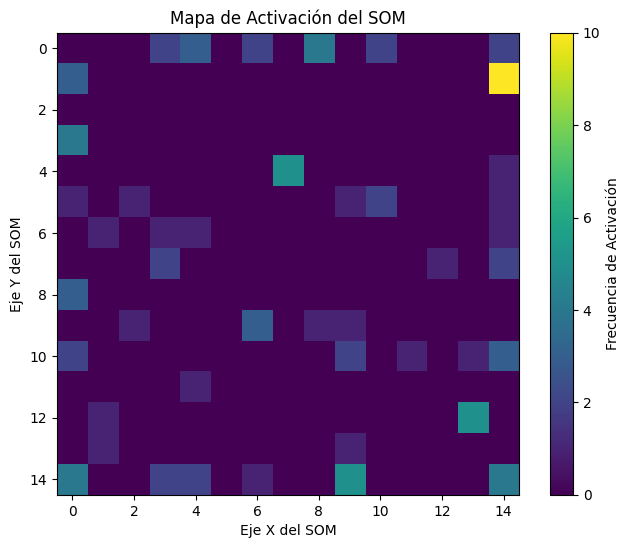

In [308]:
activation_map = np.zeros((map_side, map_side))

for x in train_array:
    bmu_idx = calculate_bmu(x, model)[1]
    activation_map[bmu_idx] += 1

plt.figure(figsize=(8, 6))
plt.imshow(activation_map, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Frecuencia de Activación")
plt.title("Mapa de Activación del SOM")
plt.xlabel("Eje X del SOM")
plt.ylabel("Eje Y del SOM")
plt.show()

##Activation 3D Histogram

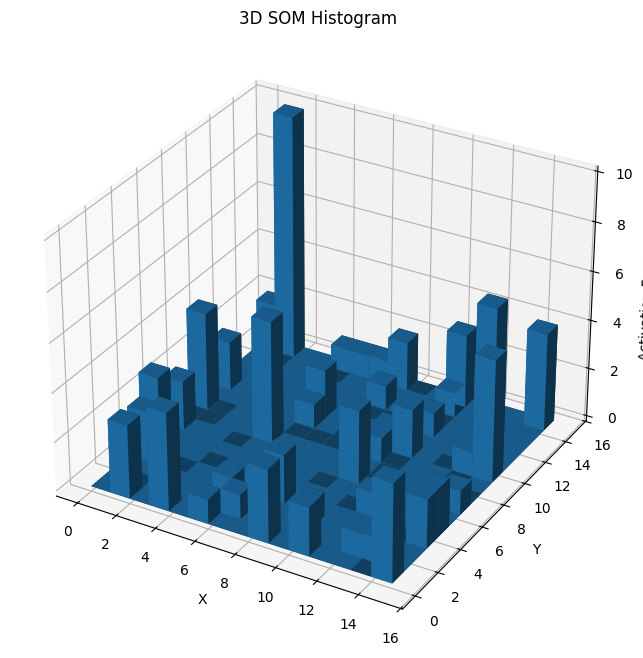

In [309]:
x, y = np.indices(activation_map.shape)
x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)

z_height = activation_map.flatten()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x, y, z, 1, 1, z_height, shade=True, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Activation Frecuency')
ax.set_title('3D SOM Histogram')

plt.show()

##U-Matrix

In [310]:
def calculate_u_matrix(weights, map_side):
    u_matrix = np.zeros((map_side, map_side))

    for i in range(map_side):
        for j in range(map_side):
            neuron_weight = weights[i, j]

            distance_sum = 0
            count = 0

            for x, y in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                if 0 <= x < map_side and 0 <= y < map_side:
                    neighbor_weight = weights[x, y]
                    distance_sum += np.linalg.norm(neuron_weight - neighbor_weight)
                    count += 1

            if count > 0:
                u_matrix[i, j] = distance_sum / count

    return u_matrix
u_matrix = calculate_u_matrix(model, map_side)

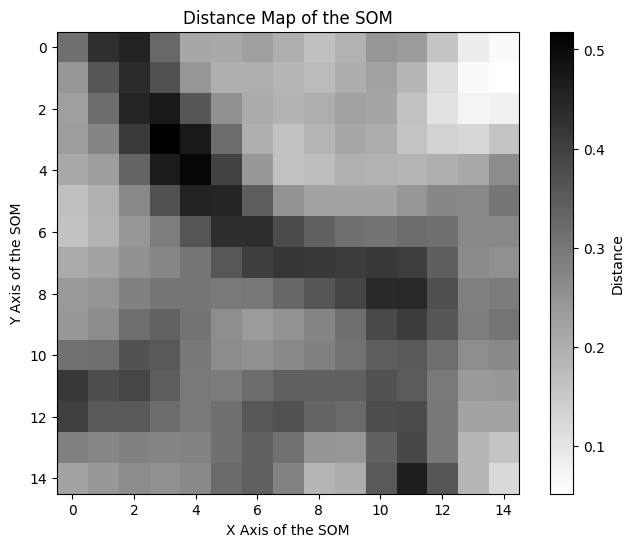

In [311]:
plt.figure(figsize=(8, 6))
plt.imshow(u_matrix, cmap="gray_r", interpolation="nearest")
plt.colorbar(label="Distance")
plt.title("Distance Map of the SOM")
plt.xlabel("X Axis of the SOM")
plt.ylabel("Y Axis of the SOM")
plt.show()

##Test Animals

In [312]:
# Extract animals from the test dataset
animal_names_test = test_data['animal_name'].values

# Normalize the test set
normalized_test_data = scaler.transform(test_data.drop(columns=['animal_name']))

# Calculates the BMU of each test sample
test_bmu_indices = [tuple(calculate_bmu(x, model)[1])
                    for x in normalized_test_data]

# Assigns each test to the cluster of its neuron
test_clusters = [ label_map[i, j]
                  for i, j in test_bmu_indices ]

# Mount the results DataFrame
test_bmu_df = pd.DataFrame({
    "Animal":  animal_names_test,
    "BMU":      test_bmu_indices,
    "Cluster": test_clusters
})

sorted_test = test_bmu_df.sort_values("Cluster")
print("Animales de TEST asignados a cada neurona y cluster:")
for _, row in sorted_test.iterrows():
    print(f"Neuron {row['BMU']} (Cluster {row['Cluster']}): {row['Animal']}")

Animales de TEST asignados a cada neurona y cluster:
Neuron (np.int64(4), np.int64(7)) (Cluster 0): oryx
Neuron (np.int64(4), np.int64(7)) (Cluster 0): giraffe
Neuron (np.int64(8), np.int64(2)) (Cluster 2): vulture


##Visualization of the Test Animals

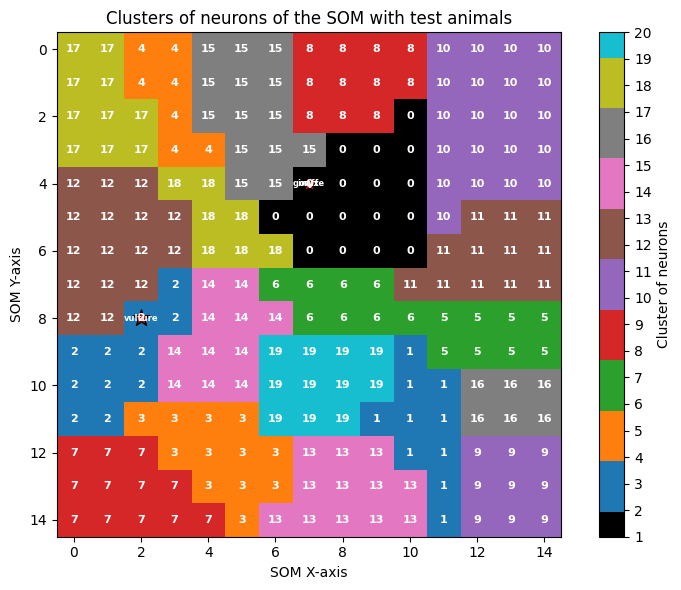


----- TEST animals per neuron and cluster -----
Neuron (np.int64(4), np.int64(7)) (Cluster 0): oryx
Neuron (np.int64(4), np.int64(7)) (Cluster 0): giraffe
Neuron (np.int64(8), np.int64(2)) (Cluster 2): vulture


In [313]:
# Prepare the data
if isinstance(normalized_test_data, pd.DataFrame):
    test_array = normalized_test_data.values
else:
    test_array = normalized_test_data

# Calculates the BMU of each test sample
test_bmu_indices = [tuple(calculate_bmu(x, model)[1]) for x in test_array]
animal_names_test = test_data['animal_name'].values

# Assigns to each test the cluster of its BMU neuron
test_clusters = [label_map[i, j] for i, j in test_bmu_indices]

# Assemble the DataFrame and sort it by cluster
test_bmu_df = pd.DataFrame({
    "Cluster": test_clusters,
    "Animal":  animal_names_test,
    "BMU":      test_bmu_indices
})
sorted_test = test_bmu_df.sort_values("Cluster")

# Plot the map of neuron clusters
plt.figure(figsize=(8,6))
plt.imshow(label_map+1, cmap=custom_cmap, interpolation="nearest")
plt.colorbar(label="Cluster of neurons",
             ticks=range(1, label_map.max()+2))
plt.title("Clusters of neurons of the SOM with test animals")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")

# Note the number of clusters in each neuron
m, n = label_map.shape
for i in range(m):
    for j in range(n):
        cid = label_map[i, j]
        plt.text(j, i, str(cid),
                 ha='center', va='center',
                 color='white', fontsize=8, fontweight='bold')

# Overlays each test animal
for (i, j), name in zip(test_bmu_indices, animal_names_test):
    plt.scatter(j, i, marker="*", s=150,
                edgecolors="black", facecolors="red")
    plt.text(j, i, name,
             ha='center', va='center',
             color='white', fontsize=6, fontweight='bold')

plt.tight_layout()
plt.show()

# Print assignments
print("\n----- TEST animals per neuron and cluster -----")
for _, row in sorted_test.iterrows():
    print(f"Neuron {row['BMU']} (Cluster {row['Cluster']}): {row['Animal']}")

##Visualization of the Oryx

Since the Giraffe and Oryx have the same neuron, we plot a part the oryx so you can properly see that both of them are in the same place

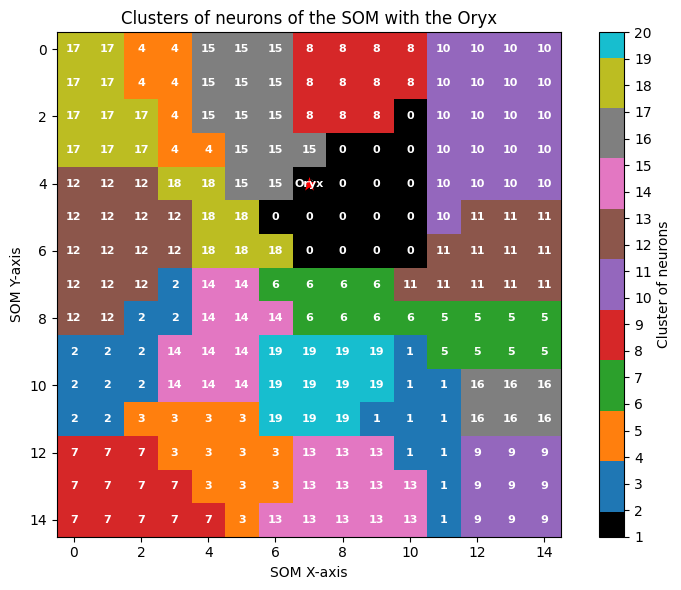


Neuron (np.int64(4), np.int64(7)) (Cluster 0): Oryx


In [314]:
# Find the index of “Oryx” in the test name array
oryx_index = np.where(animal_names_test == "oryx")[0][0]

# BMU neuron and its cluster
oryx_bmu     = test_bmu_indices[oryx_index]
oryx_cluster = test_clusters[oryx_index]

# Plot the map of neuron clusters
plt.figure(figsize=(8,6))
plt.imshow(label_map+1, cmap=custom_cmap, interpolation="nearest")
plt.colorbar(label="Cluster of neurons",
             ticks=range(1, num_clusters+1))
plt.title("Clusters of neurons of the SOM with the Oryx")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")

# Note the number of clusters in each neuron
for i in range(map_side):
    for j in range(map_side):
        cid = label_map[i, j]
        plt.text(j, i, str(cid),
                 ha='center', va='center',
                 color='white', fontsize=8, fontweight='bold')

# Highlight the position of Oryx
i, j = oryx_bmu
plt.scatter(j, i, marker="*", s=200,
            edgecolors="black", facecolors="red", zorder=5)
plt.text(j, i, "Oryx",
         ha='center', va='center',
         color='white', fontsize=8, fontweight='bold', zorder=6)

plt.tight_layout()
plt.show()

# Print Oryx neuron and cluster
print(f"\nNeuron {oryx_bmu} (Cluster {oryx_cluster}): Oryx")